In [ ]:
import json
import py_vncorenlp
import re
import tqdm

def normalizeText (text, model):
    text = text.lower()
    parsed = model.word_segment(text)
    
    words = []
    for item in parsed:
        words += item.split(' ')
        
    words = [word for word in words if re.search(r'[a-zA-Z0-9À-Ỹà-ỹĂăÂâÊêÔôƠơƯưĐđ]', word)]
    text = ' '.join(words)
    
    for stopword in stopWords:
        # Dùng regex để thay thế stopword khi nó là một từ hoặc cụm từ độc lập
        pattern = r'\b' + re.escape(stopword) + r'\b'
        text = re.sub(pattern, '', text)
        
    text = " ".join([word.strip() for word in text.split(' ') if word != ""])
    return text

# Thay bằng đường dẫn của mn
model = py_vncorenlp.VnCoreNLP(save_dir = "C:\\Users\\Admin\\Documents\\VnCoreNLP")

stopWords = []
# Sau khi load model xong, nó bị 1 vấn đề là os.getcwd() nó ăn theo thư mục của VnCoreNLP, nên khi open các file về sau sẽ phải specify rõ đường dẫn đầy đủ như cách t đã làm bên dưới 
with open ("F:\\ZDATA C\\Documents\\HCMUS\\ThirdYear\\SecondSemester\\Text Mining\\Project\\vietnamese-stopwords-dash.txt", 'r', encoding = 'utf-8') as file:
    stopWords += [word.strip('\n') for word in file.readlines()]
    
with open ("F:\\ZDATA C\\Documents\\HCMUS\\ThirdYear\\SecondSemester\\Text Mining\\Project\\vietnamese-stopwords.txt", 'r', encoding = 'utf-8') as file:
    stopWords += [word.strip('\n') for word in file.readlines()]

with open('F:\\ZDATA C\\Documents\\HCMUS\\ThirdYear\\SecondSemester\\Text Mining\\Project\\Dataset\\train_part_1.json', 'r', encoding='utf-8') as file:
    train_data = json.load(file)

vocab = dict()

# Dùng tqdm để hiển thị tiến trình của vòng lặp ngoài
for img in tqdm(train_data, desc = "Processing images"):
    QAs = train_data[img]
    for QA in QAs:
        answer = normalizeText(QA["Answer"], model = model)
        words = answer.split(' ')
        for word in words:
            if vocab.get(word) is None:
                vocab[word] = 1
            else:
                vocab[word] += 1

# Lưu vocab vào file train_vocab.txt
with open('train_vocab_answer_1.txt', 'w', encoding='utf-8') as file:
    for word, count in vocab.items():
        file.write(f"{word}: {count}\n")
        
print("Vocab saved to train_vocab_answer_1.txt")

In [1]:
def load_vocab(file_path):
    vocab = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            key, freq = line.strip().split(': ')
            freq = int(freq)
            
            # Làm sạch key
            clean_key = key.strip('-.,;:"\'()[]{}').replace('_', ' ')
            
            # Nếu key đã tồn tại thì cộng dồn tần suất
            if clean_key in vocab:
                vocab[clean_key] += freq
            else:
                vocab[clean_key] = freq
    return vocab

# Load từ điển từ hai file
train_vocab = load_vocab('train_vocab.txt')
val_vocab = load_vocab('val_vocab_ques.txt')

# Gộp hai từ điển bằng cách cộng dồn nếu trùng key
for key, freq in val_vocab.items():
    if key in train_vocab:
        train_vocab[key] += freq
    else:
        train_vocab[key] = freq

# Kiểm tra kết quả
print(train_vocab)

{'bao nhiêu': 131224, 'loại': 5949, 'phương tiện': 1123, 'liệt kê': 15734, 'tải trọng': 60, 'antonov': 15, 'an-225': 3, 'mriya': 3, 'số lượng': 9656, 'lớn': 11308, '2': 3365, 'thông số': 1378, 'kỹ thuật': 1037, 'giá trị': 5522, '10.000': 234, 'tên': 15455, 'gọi': 1089, 'bắt đầu': 11554, 'bằng': 18680, 'chữ': 15264, 'xe': 3329, 'hình dạng': 877, 'tương tự': 71, 'xe tăng': 236, 'thể hiện': 9920, 'đếm': 4856, 'hình ảnh': 12291, 'máy bay': 1005, 'góc': 1390, 'hai': 2289, 'cánh': 294, 'kích thước': 234, '20': 1400, 'trọng lượng': 54, 'động cơ': 190, 'thông tin': 5728, 'hiệu suất': 128, 'bay': 429, 'km/h': 167, 'b-17': 1, 'hiển thị': 3789, 'thân': 173, 'không': 3305, 'tính': 1694, 'logo': 1260, 'minh hoạ': 3223, 'tổ': 85, 'lái': 48, 'cánh quạt': 44, 'wright': 1, 'r-1820': 1, '97': 6, 'vũ khí': 1590, 'mục': 3123, 'hệ thống': 229, 'a': 1228, 'dassault': 6, 'rafale': 13, '10': 3064, 'viết': 2975, 'hoa': 2315, 'đoạn': 1273, 'mô tả': 4936, 'chiến tranh': 23, 'điện tử': 194, 'thales': 3, 'spectra'

In [ ]:
def add_special_tokens_and_reindex(vocab: dict, special_tokens = None, min_frequency = 4):
    """
    Thêm special tokens và đánh số lại vocab sau khi lọc theo min_frequency.

    Args:
        vocab (dict): Dạng {token: frequency}.
        special_tokens (list, optional): Danh sách các token đặc biệt. Mặc định: ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]
        min_frequency (int): Ngưỡng tần suất tối thiểu để giữ lại token.

    Returns:
        dict: Dạng {token: index}.
    """
    if special_tokens is None:
        special_tokens = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]

    # Loại bỏ các special tokens nếu có sẵn trong vocab
    for token in special_tokens:
        vocab.pop(token, None)

    # Lọc các token theo min_frequency
    filtered_tokens = [token for token, freq in vocab.items() if freq >= min_frequency]

    # Ghép special tokens vào đầu
    all_tokens = special_tokens + filtered_tokens

    return {token: idx for idx, token in enumerate(all_tokens)}

train_index_vocab = add_special_tokens_and_reindex(train_vocab)
print(len(train_index_vocab))

6532


In [ ]:
import json

def save_vocab_to_json(vocab: dict, file_path: str):
    """
    Lưu từ điển vocab đã đánh số index vào file JSON.

    Args:
        vocab (dict): Từ điển vocab dạng {token: index}.
        file_path (str): Đường dẫn file JSON để lưu.
    """
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(vocab, f, ensure_ascii=False, indent = 4)
    print(f"✅ Saved vocab to {file_path}")

save_vocab_to_json(train_index_vocab, 'question_vocab.json')

✅ Saved vocab to question_vocab.json


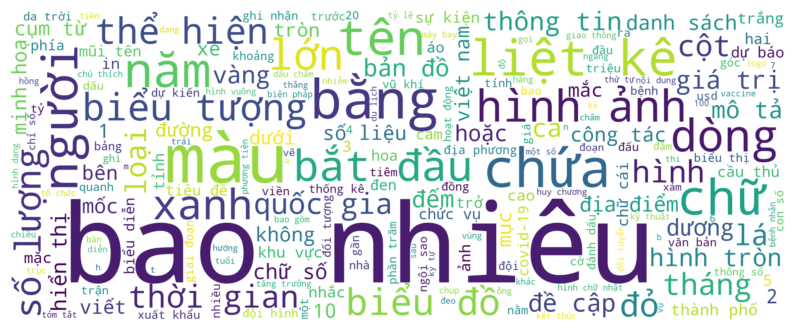

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tạo word cloud từ vocab
wordcloud = WordCloud(width = 2000, height = 800, background_color = 'white').generate_from_frequencies(train_vocab)

# Hiển thị word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ẩn trục tọa độ
plt.show()

In [20]:
def load_vocab(file_paths):
    vocab = {}
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                key, freq = line.strip().split(': ')
                freq = int(freq)
                
                # Làm sạch key
                clean_key = key.strip('-.,;:"\'()[]{}').replace('_', ' ')
                
                # Nếu key đã tồn tại thì cộng dồn tần suất
                if clean_key in vocab:
                    vocab[clean_key] += freq
                else:
                    vocab[clean_key] = freq
    return vocab

# Danh sách các file vocab
file_paths = [
    'train_vocab_answer_1.txt',
    'train_vocab_answer_2.txt',
    'train_vocab_answer_3.txt',
    'val_vocab_ans.txt'
]

# Load và gộp từ điển
combined_vocab = load_vocab(file_paths)
ans_vocab = add_special_tokens_and_reindex(combined_vocab)
print(len(ans_vocab))

# Kiểm tra kết quả
save_vocab_to_json(ans_vocab, 'answer_vocab.json')

7901
✅ Saved vocab to answer_vocab.json


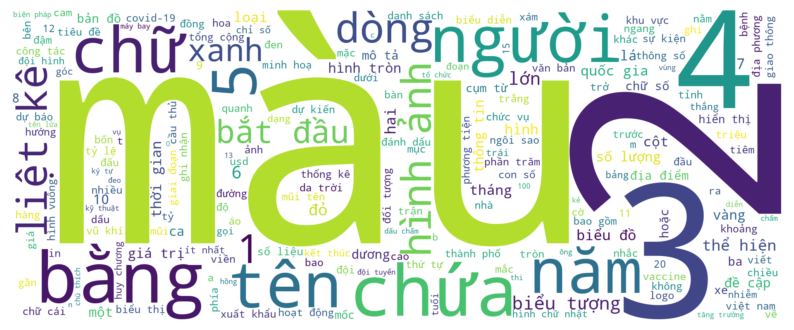

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tạo word cloud từ vocab
wordcloud = WordCloud(width = 2000, height = 800, background_color = 'white').generate_from_frequencies(combined_vocab)

# Hiển thị word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ẩn trục tọa độ
plt.show()